In [1]:
from architecture import *
from utils import *
import time

seed_everything()

# Toy Example (Generate sinusoid)
t = np.linspace(0, 4 * np.pi, 10000)
clean_data = np.sin(t)
true_signal = min_max(clean_data)

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

dtype = torch.float32
signal_np = true_signal
noise = np.random.normal(0, 0.1, 10000)  # Gaussian noise
signal_noisy_np = true_signal + noise
signal_noisy_np = add_outliers(signal_noisy_np ,10)

# Convert numpy arrays to torch tensors
signal_var = torch.from_numpy(signal_np).type(dtype).unsqueeze(0)
signal_noisy_var = torch.from_numpy(signal_noisy_np).type(dtype).unsqueeze(0)
signal_noisy_var = signal_noisy_var.unsqueeze(0)


OPT_OVER = 'net' # 'net,input'
reg_noise_std = 0.03
LR = 0.01
lambda_huber = 0.001 
OPTIMIZER='adam'
alpha=0.5
num_iter = 27
net = skip().to(device)
net_input = guided_input(signal_noisy_np, device)

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
HLF = torch.nn.HuberLoss(reduction='mean', delta = lambda_huber).type(dtype)


# Initialize variables for both direct and smoothed outputs
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
mse_last = 0

# Track best metrics for direct output (out)
best_mse_gt = float('inf')
best_mse_gt_iter = 0
best_snr = float('-inf')
best_snr_iter = 0
best_rmse = float('inf')
best_rmse_iter = 0
best_mae = float('inf')
best_mae_iter = 0

# Track best metrics for smoothed output (out_avg)
best_mse_gt_sm = float('inf')
best_mse_gt_sm_iter = 0
best_snr_sm = float('-inf')
best_snr_sm_iter = 0
best_rmse_sm = float('inf')
best_rmse_sm_iter = 0
best_mae_sm = float('inf')
best_mae_sm_iter = 0

i = 0

# Initialize lists to track SNR for each iteration
snr_values = []         # For direct output
snr_values_sm = []      # For smoothed output

def closure():
    global i, out_avg, mse_last, last_net, net_input
    global best_mse_gt, best_mse_gt_iter, best_mse_gt_sm, best_mse_gt_sm_iter
    global best_snr, best_snr_iter, best_rmse, best_rmse_iter, best_mae, best_mae_iter
    global best_snr_sm, best_snr_sm_iter, best_rmse_sm, best_rmse_sm_iter, best_mae_sm, best_mae_sm_iter
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * alpha + out.detach() * (1 - alpha)
            
    total_loss = HLF(out, signal_noisy_var.to(device))
    total_loss.backward()
    
    out_np = out.detach().cpu().squeeze().numpy()
    out_avg_np = out_avg.detach().cpu().squeeze().numpy()
    
    # Calculate metrics for direct output
    mse_gt = mse(signal_np.astype(np.float32), out_np.squeeze())
    snr_value = snr(signal_np.astype(np.float32), out_np.squeeze())
    rmse_value = rmse(signal_np.astype(np.float32), out_np.squeeze())
    mae_value = mae(signal_np.astype(np.float32), out_np.squeeze())
    
    # Calculate metrics for smoothed output
    mse_gt_sm = mse(signal_np.astype(np.float32), out_avg_np.squeeze())
    snr_value_sm = snr(signal_np.astype(np.float32), out_avg_np.squeeze())
    rmse_value_sm = rmse(signal_np.astype(np.float32), out_avg_np.squeeze())
    mae_value_sm = mae(signal_np.astype(np.float32), out_avg_np.squeeze())
    
    # Append SNR values to their respective lists
    snr_values.append(snr_value)
    snr_values_sm.append(snr_value_sm)
    
    # Print current metrics for both outputs
    print(f'Iteration {i:05d} Loss: {total_loss.item():.4f}', end='')
    print(f' Direct Output - MSE: {mse_gt:.4f} SNR: {snr_value:.2f}dB RMSE: {rmse_value:.4f} MAE: {mae_value:.4f}', end='')
    print(f' Smoothed Output - MSE: {mse_gt_sm:.4f} SNR: {snr_value_sm:.2f}dB RMSE: {rmse_value_sm:.4f} MAE: {mae_value_sm:.4f}', end='\r')
    
    # Track best metrics for direct output
    if mse_gt < best_mse_gt:
        best_mse_gt = mse_gt
        best_mse_gt_iter = i
    if snr_value > best_snr:
        best_snr = snr_value
        best_snr_iter = i
    if rmse_value < best_rmse:
        best_rmse = rmse_value
        best_rmse_iter = i
    if mae_value < best_mae:
        best_mae = mae_value
        best_mae_iter = i
    
    # Track best metrics for smoothed output
    if mse_gt_sm < best_mse_gt_sm:
        best_mse_gt_sm = mse_gt_sm
        best_mse_gt_sm_iter = i
    if snr_value_sm > best_snr_sm:
        best_snr_sm = snr_value_sm
        best_snr_sm_iter = i
    if rmse_value_sm < best_rmse_sm:
        best_rmse_sm = rmse_value_sm
        best_rmse_sm_iter = i
    if mae_value_sm < best_mae_sm:
        best_mae_sm = mae_value_sm
        best_mae_sm_iter = i
    
    i += 1
    return total_loss


# Optimization remains the same
p = get_params(OPT_OVER, net, net_input)
start_time = time.time()
optimize(OPTIMIZER, p, closure, LR, num_iter)
total_runtime = time.time() - start_time

# Print best performance results for both outputs
print("\nBest metrics for direct output:")
print(f"MSE: {best_mse_gt:.4f} at iteration {best_mse_gt_iter}")
print(f"SNR: {best_snr:.2f} dB at iteration {best_snr_iter}")
print(f"RMSE: {best_rmse:.4f} at iteration {best_rmse_iter}")
print(f"MAE: {best_mae:.4f} at iteration {best_mae_iter}")

print("\nBest metrics for smoothed output:")
print(f"MSE: {best_mse_gt_sm:.4f} at iteration {best_mse_gt_sm_iter}")
print(f"SNR: {best_snr_sm:.2f} dB at iteration {best_snr_sm_iter}")
print(f"RMSE: {best_rmse_sm:.4f} at iteration {best_rmse_sm_iter}")
print(f"MAE: {best_mae_sm:.4f} at iteration {best_mae_sm_iter}")

print(f"\nTotal optimization runtime: {total_runtime:.2f} seconds")

final_out_avg_np = out_avg.detach().cpu().squeeze().numpy()

Number of params: 73517
Starting optimization with ADAM
Iteration 00026 Loss: 0.0001 Direct Output - MSE: 0.0020 SNR: 22.68dB RMSE: 0.0450 MAE: 0.0364 Smoothed Output - MSE: 0.0017 SNR: 23.39dB RMSE: 0.0415 MAE: 0.0324
Best metrics for direct output:
MSE: 0.0020 at iteration 26
SNR: 22.68 dB at iteration 26
RMSE: 0.0450 at iteration 26
MAE: 0.0355 at iteration 25

Best metrics for smoothed output:
MSE: 0.0017 at iteration 26
SNR: 23.39 dB at iteration 26
RMSE: 0.0415 at iteration 26
MAE: 0.0324 at iteration 26

Total optimization runtime: 0.66 seconds


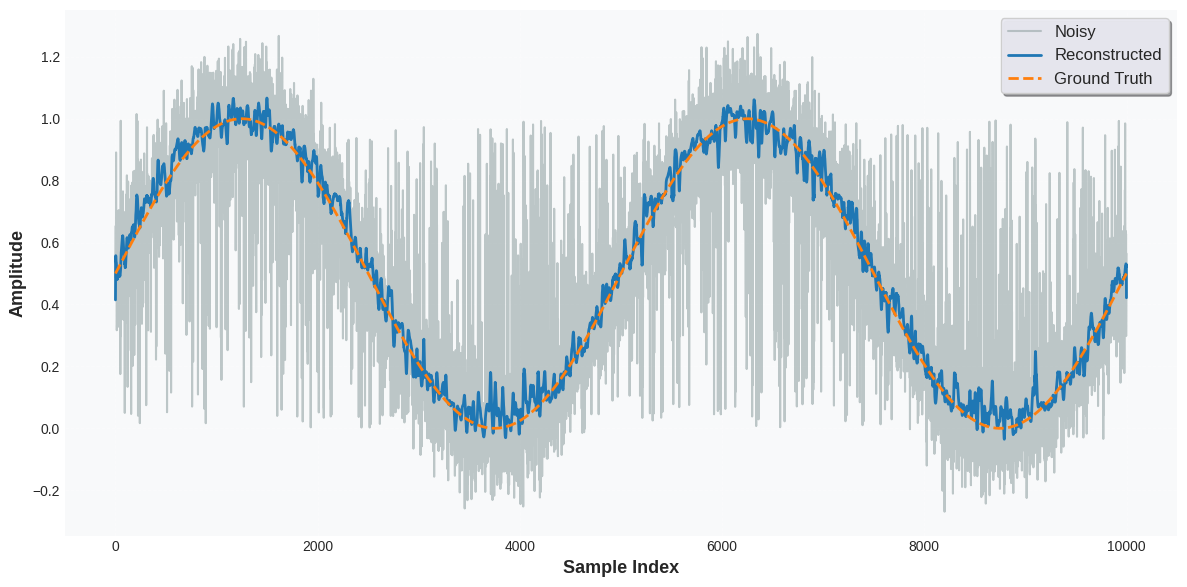

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 11

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(signal_noisy_np, label='Noisy', color='#95a5a6', 
        alpha=0.6, linewidth=1.5, zorder=1)
ax.plot(final_out_avg_np, label='Reconstructed', 
        linewidth=2, zorder=2)
ax.plot(true_signal, label='Ground Truth', 
        linewidth=2, linestyle='--', zorder=3)

ax.legend(loc='best', frameon=True, shadow=True, fontsize=12, 
          fancybox=True, framealpha=0.95)

ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)

ax.set_xlabel('Sample Index', fontsize=13, fontweight='bold')
ax.set_ylabel('Amplitude', fontsize=13, fontweight='bold')

ax.set_facecolor('#f8f9fa')
fig.patch.set_facecolor('white')

ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()